# Basic semantic segmentation using average unpooling

In [2]:
from PIL import Image
import _pickle as pkl
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
%matplotlib inline  
print ("Packs loaded.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Packs loaded.


In [14]:
!git config --global user.email "ntuan1411t3@gmail.com"
!git config --global user.name "ntuan1411t3"

# Load dataset for semantic segmentation

In [3]:
# Location of the files
camvidpath = 'CamVid/'
# Training data
path1 = os.getcwd() + '/' + camvidpath + 'train/'
path2 = os.getcwd() + '/' + camvidpath + 'trainannot/'
trainimglist = glob.glob(path1 + '/*.png')
trainannotlist = glob.glob(path2 + '/*.png')
print ("%d train images" % (len(trainimglist)))
print ("%d train annotations" % (len(trainannotlist)))

# Test data
path1 = os.getcwd() + '/' + camvidpath + 'test/'
path2 = os.getcwd() + '/' + camvidpath + 'testannot/'
testimglist = glob.glob(path1 + '/*.png')
testannotlist = glob.glob(path2 + '/*.png')
print ("%d test images" % (len(testimglist)))
print ("%d test annotations" % (len(testannotlist)))

367 train images
367 train annotations
233 test images
233 test annotations


# Get train / test images

In [4]:
height = 128
width = 128
nrclass = 22
trainData = None
trainLabel = None
trainLabelOneHot = None
trainlen = len(trainimglist)
testData = None
testLabel = None
testLabelOneHot = None
testlen = len(testimglist)
def DenseToOneHot(labels_dense, num_classes):
    # Convert class labels from scalars to one-hot vectors. 
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
""" Train data process """ 
for (f1, f2, i) in zip(trainimglist, trainannotlist, range(trainlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, trainlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        trainData = rgb
        trainLabel = label
    else:
        trainData = np.concatenate((trainData, rgb), axis=0)
        trainLabel = np.concatenate((trainLabel, label), axis=0)
ntrain = len(trainData)
# Onehot-coded label
trainLabelOneHot = np.zeros((trainLabel.shape[0], trainLabel.shape[1]                             , trainLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = trainLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        trainLabelOneHot[:, row, col, :] = oneHot
print ("Train data process done.")     

""" Test data process """ 
for (f1, f2, i) in zip(testimglist, testannotlist, range(testlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, testlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((height, width))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((height, width), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        testData = rgb
        testLabel = label
    else:
        testData = np.concatenate((testData, rgb), axis=0)
        testLabel = np.concatenate((testLabel, label), axis=0)
# Onehot-coded label
testLabelOneHot = np.zeros((testLabel.shape[0], testLabel.shape[1], testLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = testLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        testLabelOneHot[:, row, col, :] = oneHot
print ("Test data process done.")

Train data process done.
Test data process done.


In [5]:
print ("Shape of 'trainData' is %s" % (trainData.shape,))
print ("Shape of 'trainLabel' is %s" % (trainLabel.shape,))
print ("Shape of 'trainLabelOneHot' is %s" % (trainLabelOneHot.shape,))
print ("Shape of 'testData' is %s" % (testData.shape,))
print ("Shape of 'testLabel' is %s" % (testLabel.shape,))
print ("Shape of 'testLabelOneHot' is %s" % (testLabelOneHot.shape,))

Shape of 'trainData' is (367, 128, 128, 3)
Shape of 'trainLabel' is (367, 128, 128, 1)
Shape of 'trainLabelOneHot' is (367, 128, 128, 22)
Shape of 'testData' is (233, 128, 128, 3)
Shape of 'testLabel' is (233, 128, 128, 1)
Shape of 'testLabelOneHot' is (233, 128, 128, 22)


# Define networks

In [6]:
# Define functions
x = tf.placeholder(tf.float32, [None, height, width, 3])
y = tf.placeholder(tf.float32, [None, height, width, nrclass])
keepprob = tf.placeholder(tf.float32)
# Kernels
ksize = 5
fsize = 64
initstdev = 0.01
initfun = tf.random_normal_initializer(mean=0.0, stddev=initstdev)
# initfun = None
weights = {
    'ce1': tf.get_variable("ce1", shape = [ksize, ksize, 3, fsize], initializer = initfun) ,
    'ce2': tf.get_variable("ce2", shape = [ksize, ksize, fsize, fsize], initializer = initfun) ,
    'ce3': tf.get_variable("ce3", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'ce4': tf.get_variable("ce4", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd4': tf.get_variable("cd4", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd3': tf.get_variable("cd3", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd2': tf.get_variable("cd2", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'cd1': tf.get_variable("cd1", shape = [ksize, ksize, fsize, fsize], initializer = initfun),
    'dense_inner_prod': tf.get_variable("dense_inner_prod", shape= [1, 1, fsize, nrclass]
                                       , initializer = initfun) # <= 1x1conv
}
biases = {
    'be1': tf.get_variable("be1", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be2': tf.get_variable("be2", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be3': tf.get_variable("be3", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'be4': tf.get_variable("be4", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd4': tf.get_variable("bd4", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd3': tf.get_variable("bd3", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd2': tf.get_variable("bd2", shape = [fsize], initializer = tf.constant_initializer(value=0.0)),
    'bd1': tf.get_variable("bd1", shape = [fsize], initializer = tf.constant_initializer(value=0.0))
}

# DeconvNet model

In [7]:
# input : [m, h, w, c]
def Unpooling(inputOrg, size, mask=None):
    # m, c, h, w order
    m = size[0]
    h = size[1]
    w = size[2]
    c = size[3]
    input = tf.transpose(inputOrg, [0, 3, 1, 2])
    x = tf.reshape(input, [-1, 1])
    k = np.float32(np.array([1.0, 1.0]).reshape([1,-1]))
    output = tf.matmul(x, k)
    output = tf.reshape(output,[-1, c, h, w * 2])
    # m, c, w, h
    xx = tf.transpose(output, [0, 1, 3, 2])
    xx = tf.reshape(xx,[-1, 1])
    output = tf.matmul(xx, k)
    # m, c, w, h
    output = tf.reshape(output, [-1, c, w * 2, h * 2])
    output = tf.transpose(output, [0, 3, 2, 1])
    outshape = tf.stack([m, h * 2, w * 2, c])
    if mask != None:
        dense_mask = tf.sparse_to_dense(mask, outshape, output, 0)
        return output, dense_mask
    else:
        return output

# DeconvNet Model
def Model(_X, _W, _b, _keepprob):
    use_bias = 1
    # Encoder 128x128
    encoder1 = tf.nn.conv2d(_X, _W['ce1'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder1 = tf.nn.bias_add(encoder1, _b['be1'])
    mean, var = tf.nn.moments(encoder1, [0, 1, 2])
    encoder1 = tf.nn.batch_normalization(encoder1, mean, var, 0, 1, 0.0001)
    encoder1 = tf.nn.relu(encoder1)
    encoder1 = tf.nn.max_pool(encoder1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder1 = tf.nn.dropout(encoder1, _keepprob)
    # 64x64
    encoder2 = tf.nn.conv2d(encoder1, _W['ce2'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder2 = tf.nn.bias_add(encoder2, _b['be2'])
    mean, var = tf.nn.moments(encoder1, [0, 1, 2])
    encoder2 = tf.nn.batch_normalization(encoder2, mean, var, 0, 1, 0.0001)
    encoder2 = tf.nn.relu(encoder2)
    encoder2 = tf.nn.max_pool(encoder2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder2 = tf.nn.dropout(encoder2, _keepprob)
    # 32x32
    encoder3 = tf.nn.conv2d(encoder2, _W['ce3'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder3 = tf.nn.bias_add(encoder3, _b['be3'])
    mean, var = tf.nn.moments(encoder3, [0, 1, 2])
    encoder3 = tf.nn.batch_normalization(encoder3, mean, var, 0, 1, 0.0001)
    encoder3 = tf.nn.relu(encoder3)
    encoder3 = tf.nn.max_pool(encoder3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder3 = tf.nn.dropout(encoder3, _keepprob)
    # 16x16
    encoder4 = tf.nn.conv2d(encoder3, _W['ce4'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        encoder4 = tf.nn.bias_add(encoder4, _b['be4'])
    mean, var = tf.nn.moments(encoder4, [0, 1, 2])
    encoder4 = tf.nn.batch_normalization(encoder4, mean, var, 0, 1, 0.0001)
    encoder4 = tf.nn.relu(encoder4)
    encoder4 = tf.nn.max_pool(encoder4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder4 = tf.nn.dropout(encoder4, _keepprob)
    # 8x8

    # Decoder 8x8 (128/16 = 8) fsize: 64
    decoder4 = Unpooling(encoder4, [tf.shape(_X)[0], int(height / 16), int(width / 16), fsize])
    decoder4 = tf.nn.conv2d_transpose(decoder4, _W['cd4']
                , tf.stack([tf.shape(_X)[0], ksize, ksize, fsize])
                , strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder4 = tf.nn.bias_add(decoder4, _b['bd4'])
    mean, var = tf.nn.moments(decoder4, [0, 1, 2])
    decoder4 = tf.nn.batch_normalization(decoder4, mean, var, 0, 1, 0.0001)
    decoder4 = tf.nn.relu(decoder4)
    decoder4 = tf.nn.dropout(decoder4, _keepprob)
    # 16x16
    decoder3 = Unpooling(encoder3, [tf.shape(_X)[0], int(height/8), int(width/8), fsize])
    decoder3 = tf.nn.conv2d(decoder3, _W['cd3'], strides=[1, 1, 1, 1], padding='SAME')
    
    if use_bias:
        decoder3 = tf.nn.bias_add(decoder3, _b['bd3'])
    mean, var = tf.nn.moments(decoder3, [0, 1, 2])
    decoder3 = tf.nn.batch_normalization(decoder3, mean, var, 0, 1, 0.0001)
    decoder3 = tf.nn.relu(decoder3)
    decoder3 = tf.nn.dropout(decoder3, _keepprob)
    # 32x32
    decoder2 = Unpooling(decoder3, [tf.shape(_X)[0], int(height/4), int(width/4), fsize])
    decoder2 = tf.nn.conv2d(decoder2, _W['cd2'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder2 = tf.nn.bias_add(decoder2, _b['bd2'])
    mean, var = tf.nn.moments(decoder2, [0, 1, 2])
    decoder2 = tf.nn.batch_normalization(decoder2, mean, var, 0, 1, 0.0001)
    decoder2 = tf.nn.relu(decoder2)
    decoder2 = tf.nn.dropout(decoder2, _keepprob)
    # 64x64
    decoder1 = Unpooling(decoder2, [tf.shape(_X)[0], int(height / 2), int(width / 2), fsize])
    decoder1 = tf.nn.conv2d(decoder1, _W['cd1'], strides=[1, 1, 1, 1], padding='SAME')
    if use_bias:
        decoder1 = tf.nn.bias_add(decoder1, _b['bd1'])
    mean, var = tf.nn.moments(decoder1, [0, 1, 2])
    decoder1 = tf.nn.batch_normalization(decoder1, mean, var, 0, 1, 0.0001)
    decoder1 = tf.nn.relu(decoder1)
    decoder1 = tf.nn.dropout(decoder1, _keepprob)
    # 128x128
    output = tf.nn.conv2d(decoder1, _W['dense_inner_prod'], strides=[1, 1, 1, 1], padding='SAME')
    return output

print ("Network ready")

Network ready


In [8]:
ksize

5

# Define functions

In [9]:
pred = Model(x, weights, biases, keepprob)
lin_pred = tf.reshape(pred, shape=[-1, nrclass])
lin_y = tf.reshape(y, shape=[-1, nrclass])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = lin_pred, labels = lin_y))
# Class label
predmax = tf.argmax(pred, 3)
ymax = tf.argmax(y, 3)
# Accuracy
corr = tf.equal(tf.argmax(y,3), tf.argmax(pred, 3)) 
accr = tf.reduce_mean(tf.cast(corr, "float"))
# Optimizer
optm = tf.train.AdamOptimizer(0.0001).minimize(cost)
batch_size = 4
n_epochs = 120

print ("Functions ready")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Functions ready


# Real optimization starts here

Instructions for updating:
Use `tf.global_variables_initializer` instead.
checkpoint: model_checkpoint/process-100
Restoring from checkpoint model_checkpoint/process-100
INFO:tensorflow:Restoring parameters from model_checkpoint/process-100
[00/120] trainLoss: 0.2894 trainAcc: 0.91 valLoss: 0.7682 valAcc: 0.78


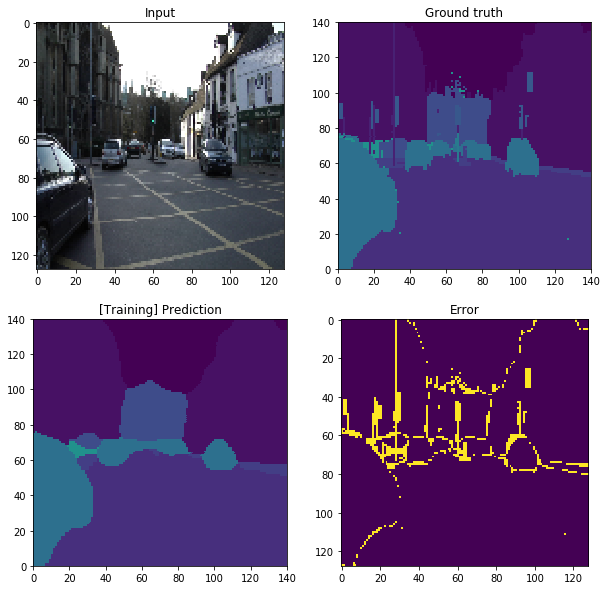

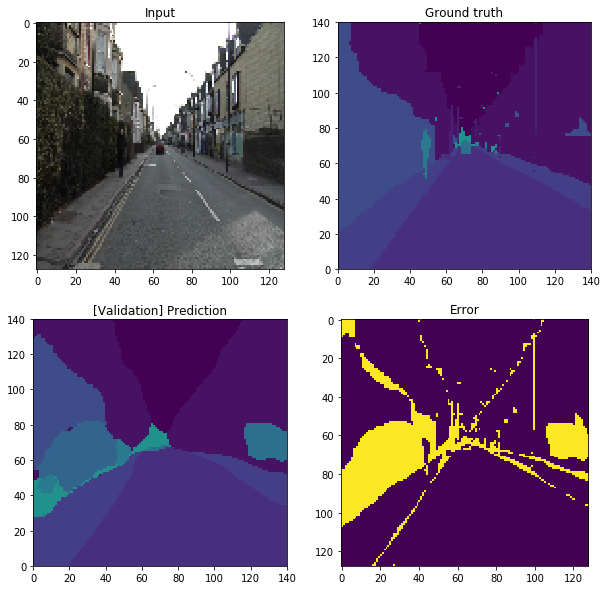

[01/120] trainLoss: 0.2942 trainAcc: 0.90 valLoss: 0.8187 valAcc: 0.78
[02/120] trainLoss: 0.2935 trainAcc: 0.90 valLoss: 0.7765 valAcc: 0.79
[03/120] trainLoss: 0.2931 trainAcc: 0.90 valLoss: 0.7630 valAcc: 0.79
[04/120] trainLoss: 0.2985 trainAcc: 0.90 valLoss: 0.7740 valAcc: 0.79
[05/120] trainLoss: 0.3006 trainAcc: 0.90 valLoss: 0.8071 valAcc: 0.77
[06/120] trainLoss: 0.2916 trainAcc: 0.91 valLoss: 0.7948 valAcc: 0.78
[07/120] trainLoss: 0.2956 trainAcc: 0.90 valLoss: 0.7902 valAcc: 0.78
[08/120] trainLoss: 0.2904 trainAcc: 0.91 valLoss: 0.8083 valAcc: 0.78
[09/120] trainLoss: 0.2838 trainAcc: 0.91 valLoss: 0.7512 valAcc: 0.79
[10/120] trainLoss: 0.2823 trainAcc: 0.91 valLoss: 0.7641 valAcc: 0.79


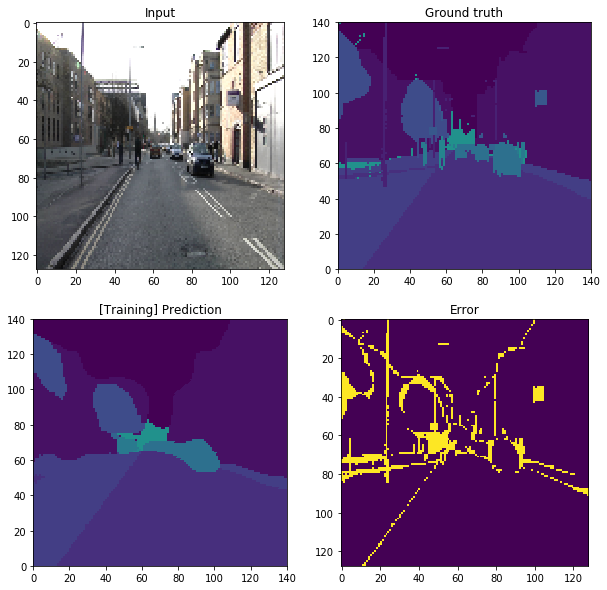

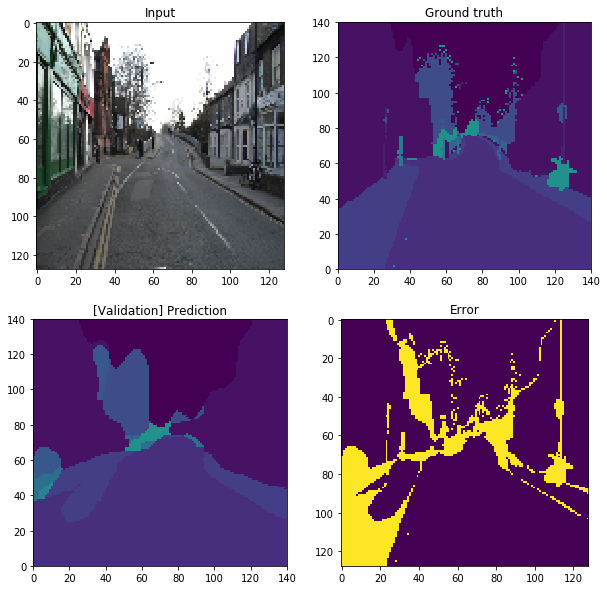

[11/120] trainLoss: 0.2952 trainAcc: 0.90 valLoss: 0.7687 valAcc: 0.79
[12/120] trainLoss: 0.2888 trainAcc: 0.91 valLoss: 0.8296 valAcc: 0.77
[13/120] trainLoss: 0.2867 trainAcc: 0.91 valLoss: 0.7700 valAcc: 0.79
[14/120] trainLoss: 0.2950 trainAcc: 0.90 valLoss: 0.7522 valAcc: 0.80
[15/120] trainLoss: 0.2952 trainAcc: 0.90 valLoss: 0.7484 valAcc: 0.79
[16/120] trainLoss: 0.2884 trainAcc: 0.91 valLoss: 0.7806 valAcc: 0.78
[17/120] trainLoss: 0.2896 trainAcc: 0.91 valLoss: 0.8126 valAcc: 0.78
[18/120] trainLoss: 0.2807 trainAcc: 0.91 valLoss: 0.7570 valAcc: 0.79
[19/120] trainLoss: 0.2834 trainAcc: 0.91 valLoss: 0.7935 valAcc: 0.78
[20/120] trainLoss: 0.2789 trainAcc: 0.91 valLoss: 0.7889 valAcc: 0.78


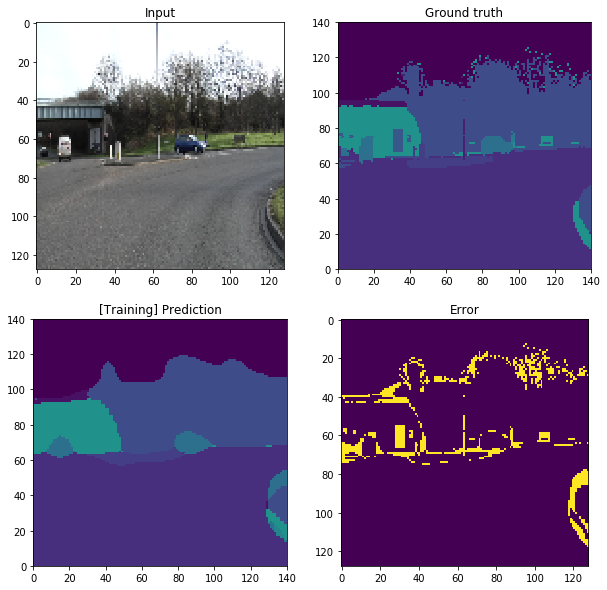

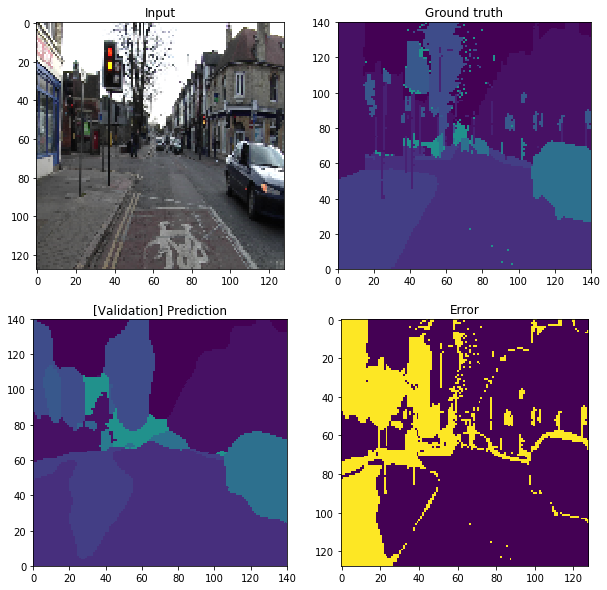

[21/120] trainLoss: 0.2897 trainAcc: 0.91 valLoss: 0.7978 valAcc: 0.77
[22/120] trainLoss: 0.2750 trainAcc: 0.91 valLoss: 0.8209 valAcc: 0.77
[23/120] trainLoss: 0.2827 trainAcc: 0.91 valLoss: 0.8052 valAcc: 0.78
[24/120] trainLoss: 0.2853 trainAcc: 0.91 valLoss: 0.8258 valAcc: 0.78
[25/120] trainLoss: 0.2793 trainAcc: 0.91 valLoss: 0.8260 valAcc: 0.78
[26/120] trainLoss: 0.2818 trainAcc: 0.91 valLoss: 0.8028 valAcc: 0.78
[27/120] trainLoss: 0.2840 trainAcc: 0.91 valLoss: 0.8110 valAcc: 0.78
[28/120] trainLoss: 0.2757 trainAcc: 0.91 valLoss: 0.7713 valAcc: 0.79
[29/120] trainLoss: 0.2746 trainAcc: 0.91 valLoss: 0.7839 valAcc: 0.79
[30/120] trainLoss: 0.2844 trainAcc: 0.91 valLoss: 0.8018 valAcc: 0.78


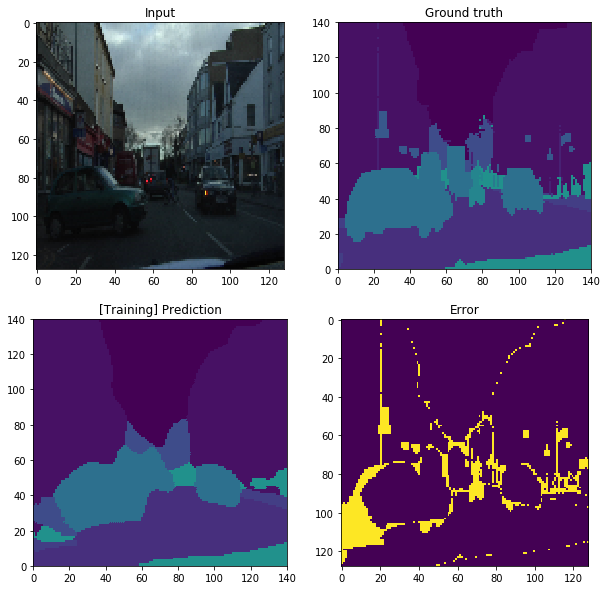

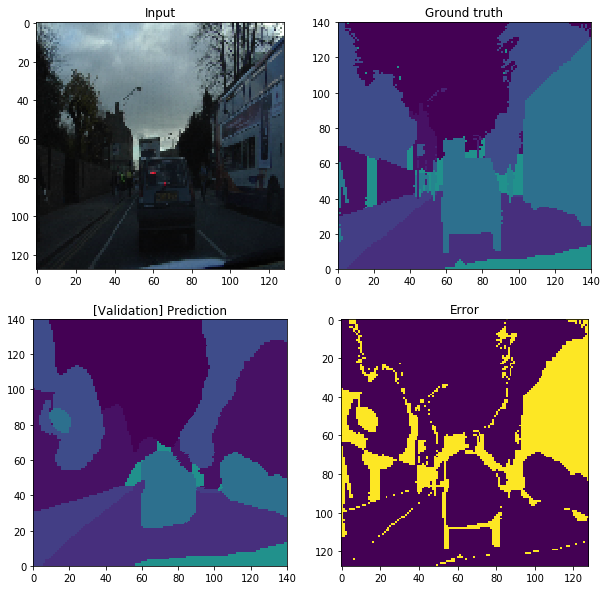

[31/120] trainLoss: 0.2853 trainAcc: 0.91 valLoss: 0.8118 valAcc: 0.77
[32/120] trainLoss: 0.2821 trainAcc: 0.91 valLoss: 0.7813 valAcc: 0.78
[33/120] trainLoss: 0.2796 trainAcc: 0.91 valLoss: 0.7839 valAcc: 0.78
[34/120] trainLoss: 0.2841 trainAcc: 0.91 valLoss: 0.7905 valAcc: 0.79
[35/120] trainLoss: 0.2792 trainAcc: 0.91 valLoss: 0.7827 valAcc: 0.78
[36/120] trainLoss: 0.2758 trainAcc: 0.91 valLoss: 0.7695 valAcc: 0.79
[37/120] trainLoss: 0.2689 trainAcc: 0.91 valLoss: 0.8425 valAcc: 0.77
[38/120] trainLoss: 0.2753 trainAcc: 0.91 valLoss: 0.8012 valAcc: 0.78
[39/120] trainLoss: 0.2813 trainAcc: 0.91 valLoss: 0.7735 valAcc: 0.79
[40/120] trainLoss: 0.2724 trainAcc: 0.91 valLoss: 0.7998 valAcc: 0.78


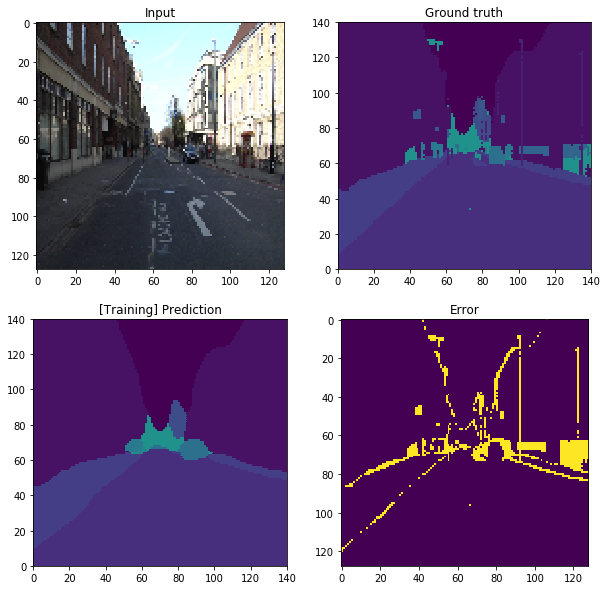

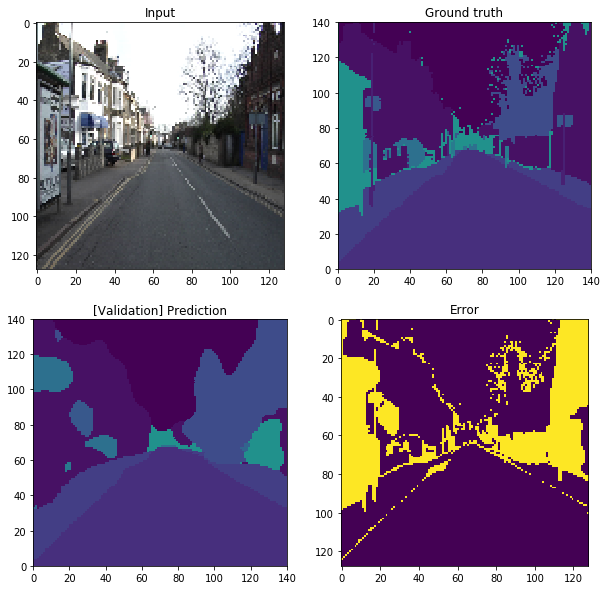

[41/120] trainLoss: 0.2743 trainAcc: 0.91 valLoss: 0.7783 valAcc: 0.78
[42/120] trainLoss: 0.2753 trainAcc: 0.91 valLoss: 0.8113 valAcc: 0.78
[43/120] trainLoss: 0.2718 trainAcc: 0.91 valLoss: 0.8023 valAcc: 0.78
[44/120] trainLoss: 0.2803 trainAcc: 0.91 valLoss: 0.8325 valAcc: 0.77
[45/120] trainLoss: 0.2767 trainAcc: 0.91 valLoss: 0.8105 valAcc: 0.78
[46/120] trainLoss: 0.2827 trainAcc: 0.91 valLoss: 0.7856 valAcc: 0.78
[47/120] trainLoss: 0.2742 trainAcc: 0.91 valLoss: 0.8167 valAcc: 0.77
[48/120] trainLoss: 0.2723 trainAcc: 0.91 valLoss: 0.7865 valAcc: 0.79
[49/120] trainLoss: 0.2685 trainAcc: 0.91 valLoss: 0.8242 valAcc: 0.77
[50/120] trainLoss: 0.2728 trainAcc: 0.91 valLoss: 0.8334 valAcc: 0.78


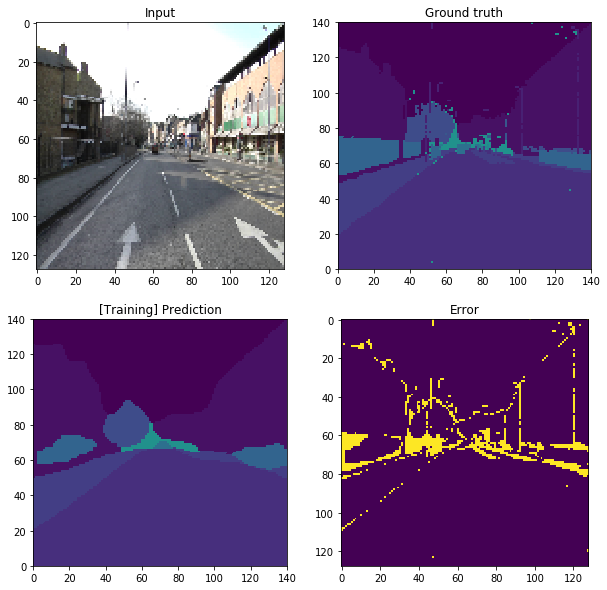

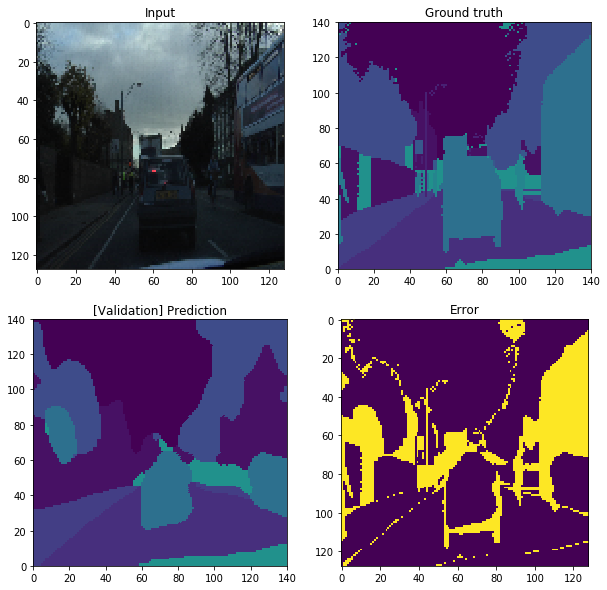

[51/120] trainLoss: 0.2796 trainAcc: 0.91 valLoss: 0.7798 valAcc: 0.79
[52/120] trainLoss: 0.2714 trainAcc: 0.91 valLoss: 0.7963 valAcc: 0.78
[53/120] trainLoss: 0.2745 trainAcc: 0.91 valLoss: 0.8134 valAcc: 0.79
[54/120] trainLoss: 0.2748 trainAcc: 0.91 valLoss: 0.7840 valAcc: 0.79
[55/120] trainLoss: 0.2699 trainAcc: 0.91 valLoss: 0.7903 valAcc: 0.79
[56/120] trainLoss: 0.2758 trainAcc: 0.91 valLoss: 0.7953 valAcc: 0.79
[57/120] trainLoss: 0.2658 trainAcc: 0.91 valLoss: 0.7893 valAcc: 0.78
[58/120] trainLoss: 0.2806 trainAcc: 0.91 valLoss: 0.8166 valAcc: 0.77
[59/120] trainLoss: 0.2666 trainAcc: 0.91 valLoss: 0.7800 valAcc: 0.78
[60/120] trainLoss: 0.2748 trainAcc: 0.91 valLoss: 0.7666 valAcc: 0.79


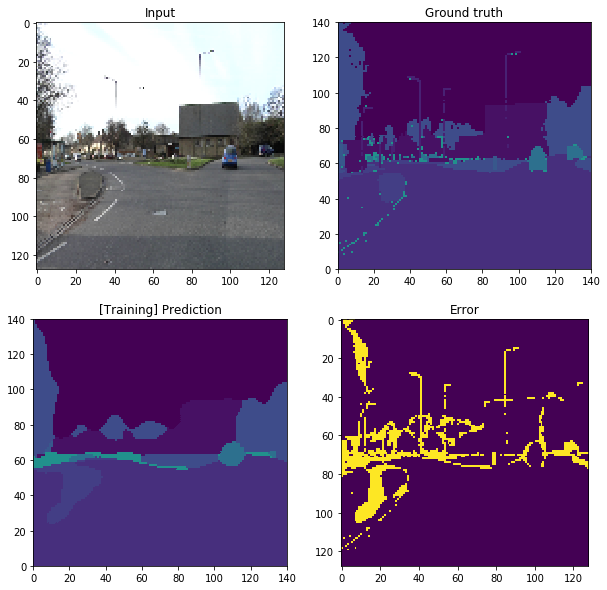

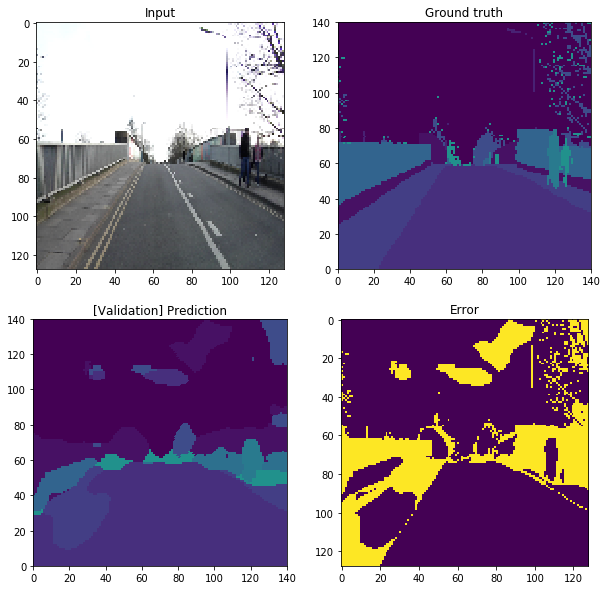

[61/120] trainLoss: 0.2681 trainAcc: 0.91 valLoss: 0.8023 valAcc: 0.79
[62/120] trainLoss: 0.2726 trainAcc: 0.91 valLoss: 0.8197 valAcc: 0.78
[63/120] trainLoss: 0.2633 trainAcc: 0.91 valLoss: 0.8103 valAcc: 0.79
[64/120] trainLoss: 0.2704 trainAcc: 0.91 valLoss: 0.7698 valAcc: 0.79
[65/120] trainLoss: 0.2656 trainAcc: 0.91 valLoss: 0.7925 valAcc: 0.78
[66/120] trainLoss: 0.2606 trainAcc: 0.91 valLoss: 0.7744 valAcc: 0.79
[67/120] trainLoss: 0.2671 trainAcc: 0.91 valLoss: 0.7980 valAcc: 0.78
[68/120] trainLoss: 0.2682 trainAcc: 0.91 valLoss: 0.7914 valAcc: 0.78
[69/120] trainLoss: 0.2635 trainAcc: 0.91 valLoss: 0.7999 valAcc: 0.78
[70/120] trainLoss: 0.2752 trainAcc: 0.91 valLoss: 0.8226 valAcc: 0.78


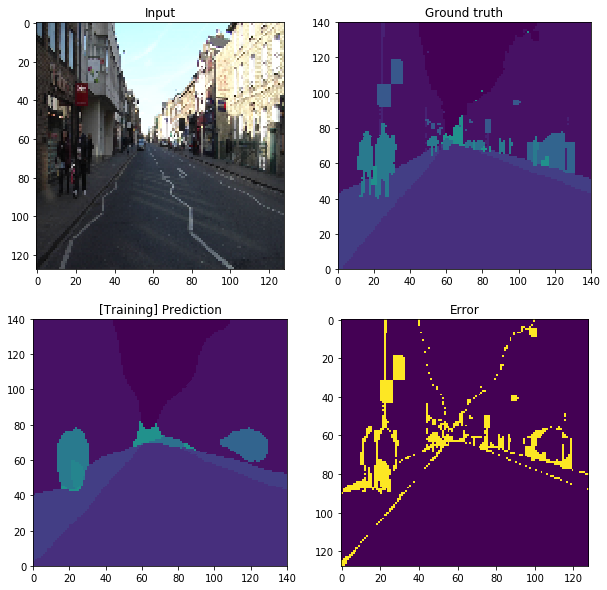

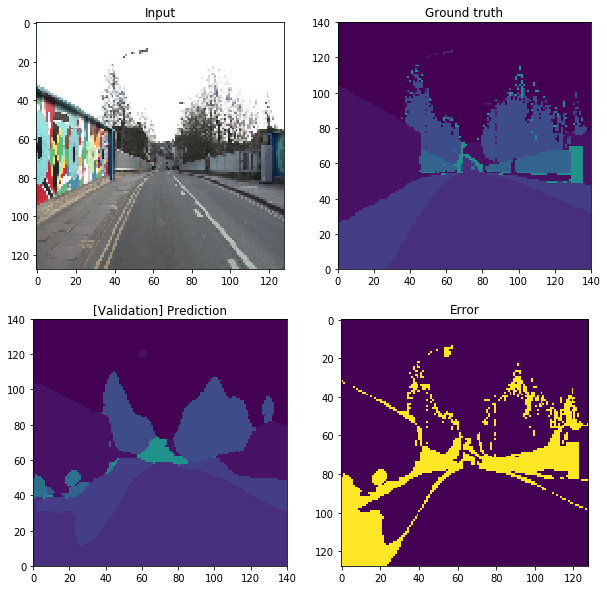

[71/120] trainLoss: 0.2700 trainAcc: 0.91 valLoss: 0.8013 valAcc: 0.79
[72/120] trainLoss: 0.2622 trainAcc: 0.91 valLoss: 0.8059 valAcc: 0.78
[73/120] trainLoss: 0.2715 trainAcc: 0.91 valLoss: 0.8526 valAcc: 0.77
[74/120] trainLoss: 0.2802 trainAcc: 0.91 valLoss: 0.7856 valAcc: 0.79
[75/120] trainLoss: 0.2629 trainAcc: 0.91 valLoss: 0.8007 valAcc: 0.78
[76/120] trainLoss: 0.2616 trainAcc: 0.91 valLoss: 0.8175 valAcc: 0.77
[77/120] trainLoss: 0.2703 trainAcc: 0.91 valLoss: 0.7824 valAcc: 0.79
[78/120] trainLoss: 0.2666 trainAcc: 0.91 valLoss: 0.8044 valAcc: 0.79
[79/120] trainLoss: 0.2632 trainAcc: 0.91 valLoss: 0.7957 valAcc: 0.78
[80/120] trainLoss: 0.2658 trainAcc: 0.91 valLoss: 0.7637 valAcc: 0.79


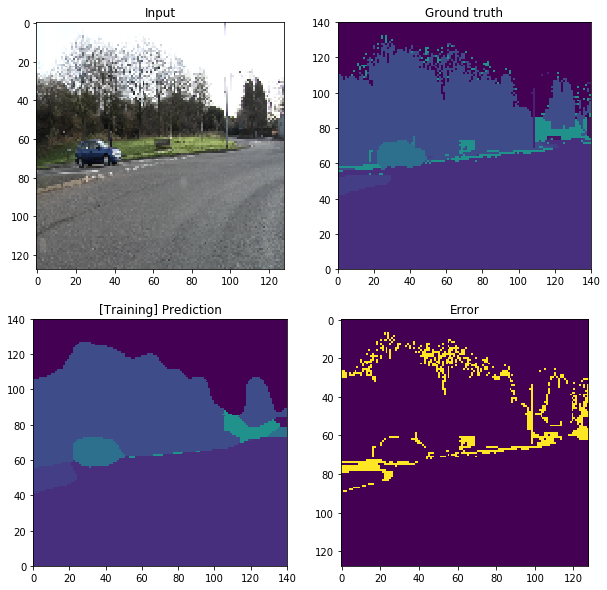

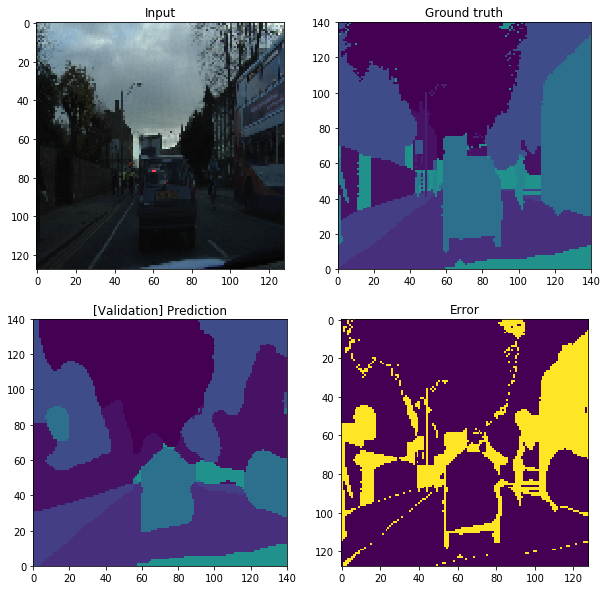

[81/120] trainLoss: 0.2622 trainAcc: 0.91 valLoss: 0.7779 valAcc: 0.79
[82/120] trainLoss: 0.2713 trainAcc: 0.91 valLoss: 0.8084 valAcc: 0.79
[83/120] trainLoss: 0.2582 trainAcc: 0.91 valLoss: 0.8514 valAcc: 0.77
[84/120] trainLoss: 0.2535 trainAcc: 0.92 valLoss: 0.8266 valAcc: 0.78
[85/120] trainLoss: 0.2590 trainAcc: 0.91 valLoss: 0.8262 valAcc: 0.78
[86/120] trainLoss: 0.2594 trainAcc: 0.91 valLoss: 0.7978 valAcc: 0.79
[87/120] trainLoss: 0.2642 trainAcc: 0.91 valLoss: 0.8252 valAcc: 0.78
[88/120] trainLoss: 0.2584 trainAcc: 0.91 valLoss: 0.7844 valAcc: 0.79
[89/120] trainLoss: 0.2622 trainAcc: 0.91 valLoss: 0.8039 valAcc: 0.78
[90/120] trainLoss: 0.2670 trainAcc: 0.91 valLoss: 0.8130 valAcc: 0.78


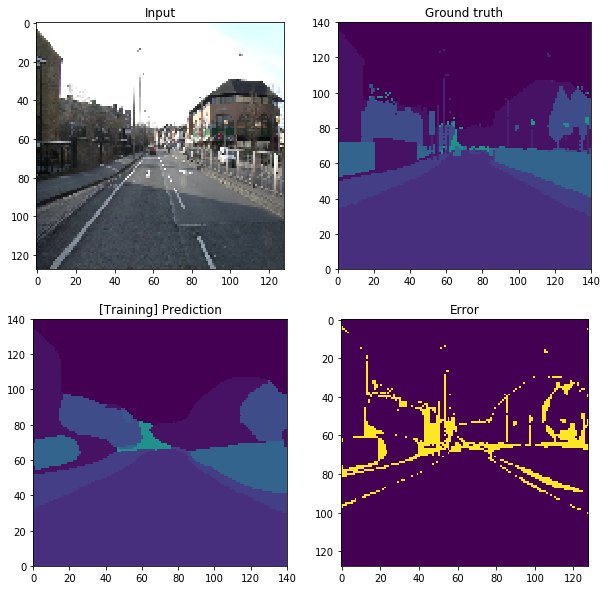

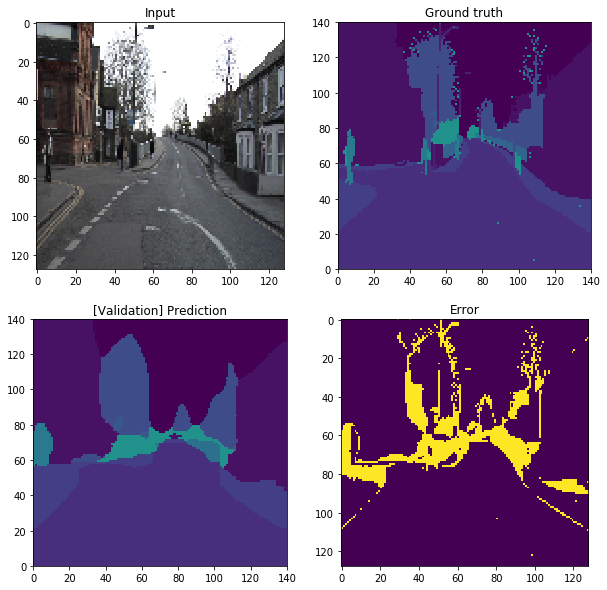

[91/120] trainLoss: 0.2583 trainAcc: 0.91 valLoss: 0.7933 valAcc: 0.79
[92/120] trainLoss: 0.2563 trainAcc: 0.92 valLoss: 0.8441 valAcc: 0.78
[93/120] trainLoss: 0.2591 trainAcc: 0.91 valLoss: 0.7936 valAcc: 0.79
[94/120] trainLoss: 0.2545 trainAcc: 0.92 valLoss: 0.7952 valAcc: 0.79
[95/120] trainLoss: 0.2579 trainAcc: 0.91 valLoss: 0.7818 valAcc: 0.79
[96/120] trainLoss: 0.2633 trainAcc: 0.91 valLoss: 0.8244 valAcc: 0.77
[97/120] trainLoss: 0.2593 trainAcc: 0.91 valLoss: 0.7991 valAcc: 0.79
[98/120] trainLoss: 0.2676 trainAcc: 0.91 valLoss: 0.8430 valAcc: 0.77
[99/120] trainLoss: 0.2535 trainAcc: 0.92 valLoss: 0.7610 valAcc: 0.79
[100/120] trainLoss: 0.2614 trainAcc: 0.91 valLoss: 0.7931 valAcc: 0.79


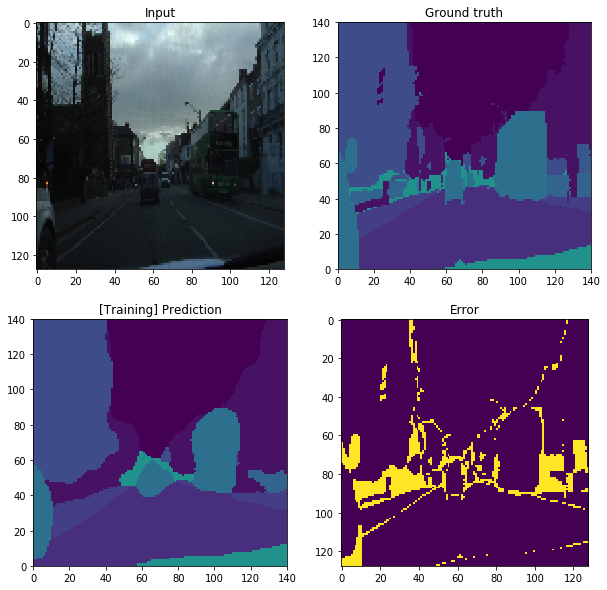

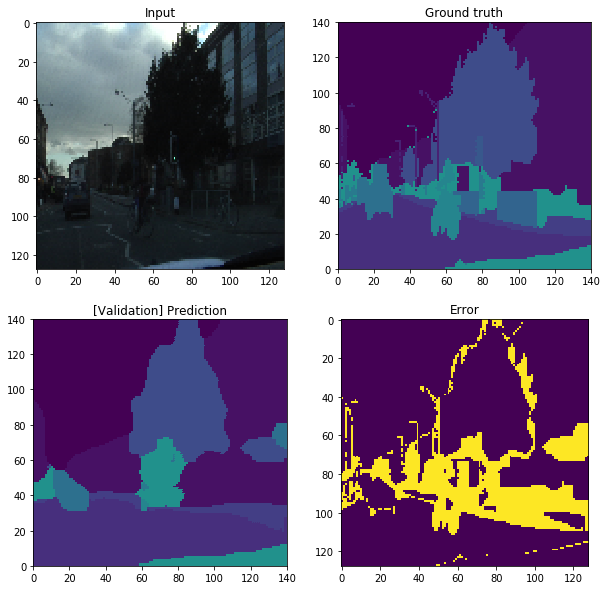

In [ ]:
resumeTraining = True
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    checkpoint = tf.train.latest_checkpoint("model_checkpoint")
    print ("checkpoint: %s" % (checkpoint))
    if resumeTraining == False:
        print ("Start from scratch")
    elif  checkpoint:
        print ("Restoring from checkpoint", checkpoint)
        saver.restore(sess, checkpoint)
    else:
        print ("Couldn't find checkpoint to restore from. Starting over.")
    
    for epoch_i in range(n_epochs):
        trainLoss = []; trainAcc = []
        num_batch = int(ntrain/batch_size)+1
        for _ in range(num_batch):
            randidx = np.random.randint(ntrain, size=batch_size)
            batchData = trainData[randidx]
            batchLabel = trainLabelOneHot[randidx]
            sess.run(optm, feed_dict={x: batchData, y: batchLabel, keepprob: 0.7}) # <== Optm is done here!
            trainLoss.append(sess.run(cost, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
            trainAcc.append(sess.run(accr, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
        # Average loss and accuracy
        trainLoss = np.mean(trainLoss)
        trainAcc = np.mean(trainAcc)
        # Run test
        valLoss = sess.run(cost, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        valAcc = sess.run(accr, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        print ("[%02d/%02d] trainLoss: %.4f trainAcc: %.2f valLoss: %.4f valAcc: %.2f" 
               % (epoch_i, n_epochs, trainLoss, trainAcc, valLoss, valAcc))
        # Save snapshot
        if resumeTraining and epoch_i % 10 == 0:
            # Save
            saver.save(sess, 'model_checkpoint/process', global_step = epoch_i)
            # Train data
            index = np.random.randint(trainData.shape[0])
            refimg = trainData[index, :, :, :].reshape(height, width, 3)
            batchData = trainData[index:index+1]
            batchLabel = trainLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            gtimg = yMaxOut[0, :, :].reshape(height, width)
            errimg = gtimg - predMaxOut[0, :, :].reshape(height, width);
            # Plot
            xs = np.linspace(0, 140, 128); ys = np.linspace(140, 0, 128)
            plt.figure(figsize=(10, 10)) 
            plt.subplot(2, 2, 1); plt.imshow(refimg); plt.title('Input')
            plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass); plt.title('Ground truth')
            plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Training] Prediction')
            plt.subplot(2, 2, 4); plt.imshow(np.abs(errimg) > 0.5); plt.title('Error')
            plt.show() 
            # Test data
            index = np.random.randint(testData.shape[0])
            batchData = testData[index:index+1]
            batchLabel = testLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            refimg = testData[index, :, :, :].reshape(height, width, 3)
            gtimg = yMaxOut[0, :, :].reshape(height, width)
            errimg = gtimg - predMaxOut[0, :, :].reshape(height, width)
            # Plot
            plt.figure(figsize=(10, 10)) 
            plt.subplot(2, 2, 1); plt.imshow(refimg); plt.title('Input')
            plt.subplot(2, 2, 2); plt.pcolor(xs, ys, gtimg, vmin=0, vmax=nrclass);  plt.title('Ground truth')
            plt.subplot(2, 2, 3); plt.pcolor(xs, ys, predMaxOut[0, :, :].reshape(height, width), vmin=0, vmax=nrclass); plt.title('[Validation] Prediction')
            plt.subplot(2, 2, 4); plt.imshow(np.abs(errimg) > 0.5); plt.title('Error')
            plt.show()

print ("Done")